In [1]:
import itertools
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import gzip
import sys, os, math
import pandas as pd
from sklearn import datasets, model_selection
from IPython import display

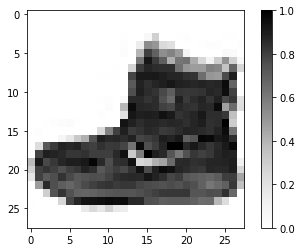

(60000, 784)


In [2]:
if torch.cuda.is_available():
    use_gpu = True

data_dir = '../data/fashion-mnist/'
save_dir = '../save/fashion-mnist/'

if not os.path.isdir(save_dir):
        os.mkdir(save_dir)

with gzip.open(data_dir + 'train-images-idx3-ubyte.gz', 'rb') as f:
    mnist_data = np.frombuffer(f.read(), np.uint8, offset=16)
    mnist_data = mnist_data.reshape(-1,784) # in reshape, -1 means the elses
    mnist_data = mnist_data / 255  # uint8
    plt.imshow(mnist_data[0].reshape(28,28), cmap='Greys')
    plt.colorbar()
    plt.show()
    print(mnist_data.shape)

In [3]:
with gzip.open(data_dir + 'train-labels-idx1-ubyte.gz', 'rb') as f:
    mnist_label = np.frombuffer(f.read(), np.uint8, offset=8)
                        # buffer, dtype=float, count=-1, offset=0(in byte)
mnist_label.shape

(60000,)

In [4]:
# numpy to tensor
train_X = torch.from_numpy(mnist_data).float()
train_Y = torch.from_numpy(mnist_label).long()

In [5]:
# train dataset loader
train = TensorDataset(train_X, train_Y)
batch_size = 100
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)

# # train_loader shape check
for n, (image, label) in enumerate(train_loader):
    if n == len(train_loader)-2:
        print(np.array(image).shape, np.array(label).shape)
    elif n == len(train_loader)-1:
        print(np.array(image).shape, np.array(label).shape, n)

(100, 784) (100,)
(100, 784) (100,) 599


In [6]:
# Model - Discriminator
class Discriminator(nn.Module):
    def __init__(self): 
        super(Discriminator, self).__init__() # nn.Module initialize
        self.model = nn.Sequential(
            nn.Linear(in_features=784, out_features=1024, bias=True),
            nn.LeakyReLU(negative_slope=0.2, inplace=True), 
            # inplace : like += or *=, existing memory location
            nn.Dropout(p=0.3),  
            nn.Linear(1024, 512),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()) # precent of real image, uniform distribution(0~1)
        
    def forward(self, x):
        out = self.model(x.view(x.size(0), 784))
        out = out.view(out.size(0), -1)
        return out

In [7]:
# Model - Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh() # normal distribution (-1~1)
        )
    def forward(self, x):
        x = x.view(x.size(0), 100)
        out = self.model(x)
        return out

In [8]:
# Model to Cuda
D = Discriminator().cuda()
G = Generator().cuda()

In [9]:
# Optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss, for 0 or 1
D_optimizer = Adam(D.parameters(), lr = 0.0002)
G_optimizer = Adam(G.parameters(), lr = 0.0002)

In [10]:
# Train - D
def D_train(D, real_image, real_label, fake_image, fake_label):
    D.zero_grad()
    output = D(real_image) # real_predict
    real_loss = criterion(output, real_label)
    
    output = D(fake_image) # fake_predict
    fake_loss = criterion(output, fake_label)
    
    D_loss = real_loss + fake_loss  # D total_loss
    D_loss.backward()
    D_optimizer.step()
    return D_loss, real_loss, fake_loss

In [11]:
# Train - G
def G_train(G, fake_predict, real_label):
    G.zero_grad()
    G_loss = criterion(fake_predict, real_label)
    G_loss.backward()
    G_optimizer.step()
    return G_loss

In [12]:
# Random noise for test 
n_test = 16
test_noise = Variable(torch.randn(n_test, 100).cuda())

Epoch [1/200], D_loss = 0.810, G_loss = 1.803


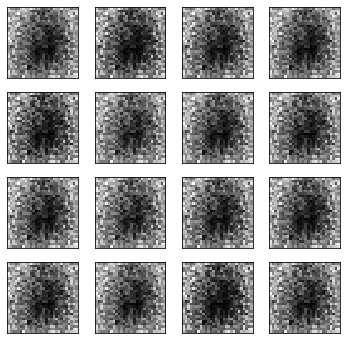

Epoch [50/200], D_loss = 0.849, G_loss = 1.365


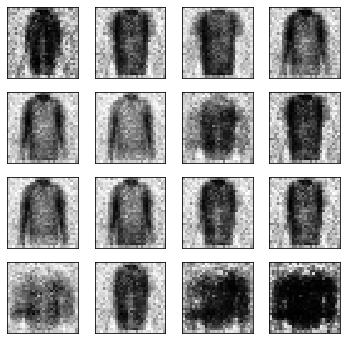

Epoch [100/200], D_loss = 0.670, G_loss = 2.454


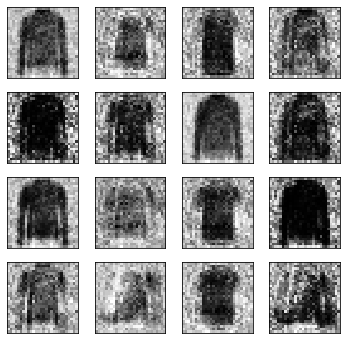

Epoch [150/200], D_loss = 1.129, G_loss = 3.543


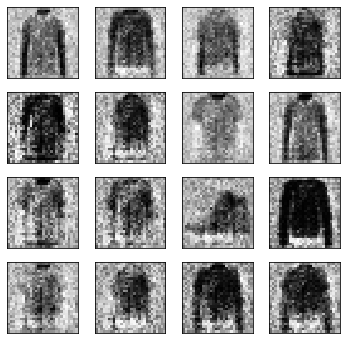

Epoch [200/200], D_loss = 1.192, G_loss = 1.217


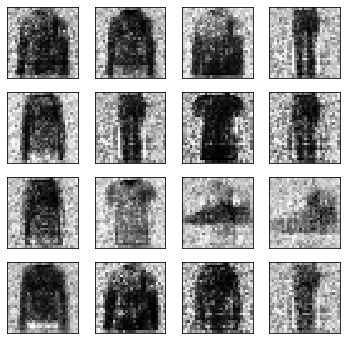

In [13]:
# image plot frame
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(6,6))
for i,j in itertools.product(range(ax.shape[0]), range(ax.shape[1])):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)

# Train start
epochs = 200

for epoch in range(epochs):
    for n, (real_image, _) in enumerate(train_loader):
        # real_image, real_label setting
        real_image = Variable(real_image.cuda())
        real_label = Variable(torch.ones(batch_size, 1).cuda()) # real_label = 1
        
        # for Discriminator training
        noise = Variable(torch.randn(batch_size, 100).cuda())
        fake_image = G(noise)
        fake_label = Variable(torch.zeros(batch_size, 1).cuda()) # fake_label = 0
        
        # Discriminator training
        D_loss, real_loss, fake_loss = D_train(D, real_image, 
                                               real_label, fake_image, fake_label)
        
        # for Generator training
        noise = Variable(torch.randn(batch_size, 100).cuda())
        fake_image = G(noise)
        fake_predict = D(fake_image)
        
        # Generator training
        G_loss = G_train(G, fake_predict, real_label)

    # test
    if epoch == 0 or (epoch+1) % 50 == 0:  
        test_image = G(test_noise)
        for i in range(n_test):
            y = i // 4
            x = i % 4
            ax[y,x].cla()
            ax[y,x].imshow(test_image[i].data.cpu().reshape(28, 28), cmap='Greys')
        plt.savefig('../save/fashion-mnist/GAN_fashion_mnist_%03d.png' % (epoch+1))
        print('Epoch [%d/%d], D_loss = %.3f, G_loss = %.3f' % (epoch + 1, epochs, D_loss.item(), G_loss.item()))
        if epoch != epochs-1:
            display.display(plt.gcf())
        

In [14]:
torch.save(Generator().state_dict(), '../save/fashion-mnist/saved_generator.pt')
# saved_generator = torch.load('./save/mnist/saved_generator.pt')

In [ ]:
# Reference code
# https://github.com/prcastro/pytorch-gan/blob/master/MNIST%20GAN.ipynb